<a href="https://colab.research.google.com/github/staocube88/AI-Model-Training/blob/master/Optimized_YOLO_FAW_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
from google.colab import drive
import time

# 1. Install YOLOv8 (Ultralytics)
!pip install ultralytics -q
# 2. Mount Google Drive
# Add a retry mechanism for mounting Google Drive
try:
    drive.mount('/content/drive')
except ValueError as e:
    print(f"Initial mount failed: {e}. Retrying after a short delay...")
    time.sleep(5) # Wait for 5 seconds before retrying
    try:
        drive.mount('/content/drive', force_remount=True) # force_remount might help
    except Exception as retry_e:
        print(f"Retry mount also failed: {retry_e}. Please check permissions or try restarting the runtime.")
        # Exit the script or handle the error as appropriate for your workflow
        raise retry_e # Re-raise the exception after printing the message


# --- Define Paths ---
# Source: Your top-level folder in Google Drive
DRIVE_ROOT = '/content/drive/MyDrive/FAW_Dataset'

# Destination: Colab's fast local disk
LOCAL_ROOT = '/content/FAW_Dataset'

print(f"Copying {DRIVE_ROOT} to local storage {LOCAL_ROOT}...")

# Remove the destination directory if it already exists
if os.path.exists(LOCAL_ROOT):
    print(f"Removing existing directory: {LOCAL_ROOT}")
    shutil.rmtree(LOCAL_ROOT)

# Copy the entire directory structure (including 'train', 'test', and their subfolders)
shutil.copytree(DRIVE_ROOT, LOCAL_ROOT)

print("✅ Initial Copy Complete! All subsequent operations will use local disk.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying /content/drive/MyDrive/FAW_Dataset to local storage /content/FAW_Dataset...
Removing existing directory: /content/FAW_Dataset
✅ Initial Copy Complete! All subsequent operations will use local disk.


In [2]:
# --- Configuration ---
# NOTE: This is the root where 'train' and 'test' folders reside
LOCAL_ROOT = '/content/FAW_Dataset'

# Your classification folders (keys) and their corresponding YOLO class IDs (values)
CLASS_MAPPING = {
    # FIX: These keys MUST EXACTLY match your folder names:
    "FAW_larva": 0,
    "FAW_damage": 1,
    "healthy_crops": 2 # Assuming this is your third class
}

# --- Define New YOLO Structure (Output) ---
# We create ONE merged folder for all data (before the final train/val split)
YOLO_ROOT = os.path.join(LOCAL_ROOT, 'YOLO_FAW_Dataset_MERGED')
os.makedirs(os.path.join(YOLO_ROOT, 'images'), exist_ok=True)
os.makedirs(os.path.join(YOLO_ROOT, 'labels'), exist_ok=True)

print("Starting conversion and merging of train/test splits...")
total_files = 0

# Iterate over the primary splits: 'train' and 'test'
for split_folder in ['train', 'test']:
    split_path = os.path.join(LOCAL_ROOT, split_folder)

    if not os.path.isdir(split_path):
        print(f"Skipping primary split folder: {split_path} (Not Found)")
        continue

    # Iterate over the classification folders inside the split (e.g., train/FAW_Larva)
    for class_name, class_id in CLASS_MAPPING.items():
        # This is the path to the images: e.g., /content/drive/MyDrive/FAW_Dataset/train/FAW_Larva
        class_folder = os.path.join(split_path, class_name)

        if not os.path.isdir(class_folder):
            print(f"  Skipping class folder: {class_folder} (Not Found)")
            continue

        # Process all image files in that specific class folder
        for filename in os.listdir(class_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                total_files += 1
                img_path = os.path.join(class_folder, filename)

                # 1. Create a unique filename for the image and label
                # This ensures images with the same name (e.g., '1.jpg') from 'train' and 'test' don't overwrite each other
                base_name = os.path.splitext(filename)[0]
                unique_filename = f"{split_folder}_{class_name}_{base_name}{os.path.splitext(filename)[1]}"
                unique_label_name = f"{split_folder}_{class_name}_{base_name}.txt"

                # 2. Copy Image to the new 'images' directory
                new_img_path = os.path.join(YOLO_ROOT, 'images', unique_filename)
                shutil.copy(img_path, new_img_path)

                # 3. Create the YOLO .txt label file
                label_path = os.path.join(YOLO_ROOT, 'labels', unique_label_name)

                # YOLO format: [class_id] [x_center] [y_center] [width] [height]
                yolo_line = f"{class_id} 0.5 0.5 1.0 1.0\n"

                with open(label_path, 'w') as f:
                    f.write(yolo_line)

print(f"\n✅ Conversion & Merging Complete! Processed {total_files} files.")
print(f"New MERGED YOLO dataset created at: {YOLO_ROOT}")

Starting conversion and merging of train/test splits...

✅ Conversion & Merging Complete! Processed 3443 files.
New MERGED YOLO dataset created at: /content/FAW_Dataset/YOLO_FAW_Dataset_MERGED


In [3]:
# Install the library designed for splitting image folders
!pip install split-folders -q
import splitfolders

In [4]:
# Install necessary libraries for splitting and YAML creation (run this cell if not done)
!pip install scikit-learn pyyaml -q
import os
import shutil
import glob
import yaml
from sklearn.model_selection import train_test_split

# --- Configuration ---
# Input: The merged folder you just created
YOLO_ROOT_INPUT = '/content/FAW_Dataset/YOLO_FAW_Dataset_MERGED'
# Output: The final structured folder for training
YOLO_ROOT_OUTPUT = '/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT'

# Define new final split paths and create directories
for folder in ['train/images', 'train/labels', 'val/images', 'val/labels']:
    os.makedirs(os.path.join(YOLO_ROOT_OUTPUT, folder), exist_ok=True)

# 1. Get a list of all image paths from the merged folder
all_image_paths = glob.glob(os.path.join(YOLO_ROOT_INPUT, 'images', '*.jpg'))

if not all_image_paths:
    print("❌ ERROR: No images found in the merged input folder. Check path and file extensions.")
    exit()

# 2. Split the paths into train (80%) and validation (20%) sets
train_paths, val_paths = train_test_split(
    all_image_paths,
    test_size=0.2,
    random_state=42
)

# 3. Function to copy files and their corresponding labels
def copy_split_files(file_paths, split_name):
    print(f"Copying {len(file_paths)} files to {split_name}...")
    img_target = os.path.join(YOLO_ROOT_OUTPUT, split_name, 'images')
    label_target = os.path.join(YOLO_ROOT_OUTPUT, split_name, 'labels')

    for img_path in file_paths:
        # Define image and label names
        filename = os.path.basename(img_path)
        base_name = os.path.splitext(filename)[0]
        label_filename = base_name + '.txt'

        # Source paths for image and label (from the MERGED folder)
        label_path_src = os.path.join(YOLO_ROOT_INPUT, 'labels', label_filename)

        # Copy image and label to the SPLIT folder
        shutil.copy(img_path, os.path.join(img_target, filename))
        shutil.copy(label_path_src, os.path.join(label_target, label_filename))

# Copy the files
copy_split_files(train_paths, 'train')
copy_split_files(val_paths, 'val')

print(f"\n✅ Data Splitting Complete! Train: {len(train_paths)} files, Val: {len(val_paths)} files.")

Copying 2718 files to train...
Copying 680 files to val...

✅ Data Splitting Complete! Train: 2718 files, Val: 680 files.


In [5]:
# Install pyyaml if needed
!pip install pyyaml -q
import yaml

# --- Updated Configuration for YOLOv8 ---
# Define the path for the split dataset root
LOCAL_SPLIT_ROOT = '/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT' # Define the variable here
LOCAL_DATA_YAML_PATH = os.path.join(LOCAL_SPLIT_ROOT, 'data.yaml')

yaml_content = {
    # Path where YOLO will look for the train/val folders (local disk)
    'path': LOCAL_SPLIT_ROOT,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 3,
    'names': ['FAW_larva', 'FAW_damage', 'healthy_crops']
}

# Write the content to a NEW file in the local directory
with open(LOCAL_DATA_YAML_PATH, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"\n✅ Updated data.yaml created locally at: {LOCAL_DATA_YAML_PATH}")


✅ Updated data.yaml created locally at: /content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml


In [6]:
from ultralytics import YOLO

# Install Ultralytics again if your runtime was disconnected after the copy
# !pip install ultralytics -q

model = YOLO('yolov8n.pt')

# Note the new path here
FAST_DATA_YAML_PATH = '/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml'

print("\n🚀 Starting FAST YOLOv8 Training...")

results = model.train(
    data=FAST_DATA_YAML_PATH,
    epochs=100,
    imgsz=640,
    name='FAW_Object_Detection_Fast',
    workers=8, # Enables parallel data loading (critical for speed)
    batch=32 # Try to maximize this value for GPU efficiency
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

🚀 Starting FAST YOLOv8 Training...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015,

In [7]:
from ultralytics import YOLO

# 1. Load the pre-trained model
model = YOLO('yolov8n.pt')

# 2. Train the model
print("\n🔥 Starting YOLOv8 Training...")
# Using the path defined in step 2
FINAL_DATA_YAML_PATH = '/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml'

results = model.train(
    data=FINAL_DATA_YAML_PATH,
    epochs=100,
    imgsz=640,
    name='FAW_Object_Detection_Final',
    patience=25 # Stop training early if validation metrics don't improve for 25 epochs
)
print("Training Complete. Weights saved.")

# 3. Export to ONNX (The Core Deliverable)
BEST_WEIGHTS_PATH = f'/content/runs/detect/FAW_Object_Detection_Final/weights/best.pt'

model_to_export = YOLO(BEST_WEIGHTS_PATH)

print("\n📦 Exporting model to ONNX format...")
model_to_export.export(
    format='onnx',
    simplify=True,
    dynamic=False,
    imgsz=640
)

print("\n🎉 Model Training and ONNX Export Finished!")
print(f"Your final deliverable model file is located within the runs folder: {os.path.dirname(BEST_WEIGHTS_PATH)}/best.onnx")


🔥 Starting YOLOv8 Training...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=FAW_Object_Detection_Final, nbs=64, nms=False, opset=None, optimize=False, optimi

In [8]:
# Copy ONNX report to Google Drive
import shutil
import os

SOURCE_PATH = '/content/runs/detect/FAW_Object_Detection_Final/weights/best.onnx'
# Target location in your Google Drive
DEST_PATH = '/content/drive/MyDrive/FAW_Dataset/best_faw_detector.onnx'

shutil.copy(SOURCE_PATH, DEST_PATH)

print(f"✅ Final ONNX model copied to Google Drive: {DEST_PATH}")

✅ Final ONNX model copied to Google Drive: /content/drive/MyDrive/FAW_Dataset/best_faw_detector.onnx


In [9]:
# Copy ONNX report to my system
from google.colab import files

files.download('/content/runs/detect/FAW_Object_Detection_Final/weights/best.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
!pip install gradio onnxruntime ultralytics -q
import gradio as gr
import onnxruntime as ort
import numpy as np
import cv2
from ultralytics.utils.plotting import Annotator, colors

In [46]:
# --- Configuration ---
ONNX_MODEL_PATH = '/content/runs/detect/FAW_Object_Detection_Final/weights/best.onnx'
# Class names must match the order in your data.yaml: 0, 1, 2
CLASS_NAMES = ['FAW_larva', 'FAW_damage', 'healthy_crops']
IMG_SIZE = 640

# Load the ONNX session once
session = ort.InferenceSession(ONNX_MODEL_PATH)
output_names = [session.get_outputs()[0].name]
input_name = session.get_inputs()[0].name

def predict_image(img_path):
    # 1. Load and Preprocess Image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and normalize for the model (640x640)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype(np.float32) / 255.0

    # Convert to C, H, W and add batch dimension: (1, 3, 640, 640)
    img_input = np.transpose(img_norm, (2, 0, 1))[np.newaxis, ...]

    # 2. Run ONNX Inference
    preds = session.run(output_names, {input_name: img_input})[0]

    # 3. Post-processing (Includes NMS steps logic)

    # Output shape: (1, 7, 8400) -> (7, 8400) -> (8400, 7)
    # The columns are [box_x, box_y, box_w, box_h, class_0_score, class_1_score, class_2_score]
    preds = np.squeeze(preds) # Shape (7, 8400)
    preds = preds.T           # Shape (8400, 7)

    # The maximum class confidence for each row (8400 potential boxes)
    class_scores = preds[:, 4:].max(axis=1) # Max score from class columns (4 to end)

    # Filter by confidence threshold (0.5 is usually fine for a trained model)
    conf_threshold = 0.25 # Lower this temporarily to ensure detection
    candidates = preds[class_scores > conf_threshold]

    if candidates.shape[0] == 0:
        print("DEBUG: No candidates found above confidence threshold.")
        return img_rgb

    # 4. Apply Non-Maximum Suppression (NMS)
    # Get final scores, classes, and boxes for the candidates
    final_scores = candidates[:, 4:].max(axis=1)
    final_classes = candidates[:, 4:].argmax(axis=1)
    final_boxes_xywh = candidates[:, :4]

    # Convert boxes from xywh to x1y1x2y2 format for NMS
    boxes_xyxy = np.copy(final_boxes_xywh)
    boxes_xyxy[:, 0] = final_boxes_xywh[:, 0] - final_boxes_xywh[:, 2] / 2  # x1 = x_center - width / 2
    boxes_xyxy[:, 1] = final_boxes_xywh[:, 1] - final_boxes_xywh[:, 3] / 2  # y1 = y_center - height / 2
    boxes_xyxy[:, 2] = final_boxes_xywh[:, 0] + final_boxes_xywh[:, 2] / 2  # x2 = x_center + width / 2
    boxes_xyxy[:, 3] = final_boxes_xywh[:, 1] + final_boxes_xywh[:, 3] / 2  # y2 = y_center + height / 2

    # Apply NMS
    iou_threshold = 0.45 # Intersection over Union threshold for NMS
    # NMS requires scores and boxes in x1y1x2y2 format
    indices_to_keep = cv2.dnn.NMSBoxes(
        boxes_xyxy.tolist(), # OpenCV NMS expects a list of lists
        final_scores.tolist(),
        conf_threshold, # Confidence threshold (already applied, but needed for NMS function signature)
        iou_threshold
    )

    # Ensure indices_to_keep is a flat list of integers
    if isinstance(indices_to_keep, np.ndarray):
        indices_to_keep = indices_to_keep.flatten().tolist()
    elif indices_to_keep is None:
        indices_to_keep = [] # Handle case where NMS returns None

    # Filter the final detections based on NMS results
    final_scores_nms = final_scores[indices_to_keep]
    final_classes_nms = final_classes[indices_to_keep]
    final_boxes_xyxy_nms = boxes_xyxy[indices_to_keep] # Keep in xyxy format for drawing

    print(f"✅ Found {final_boxes_xywh.shape[0]} detections before NMS.") # DEBUG: Check the count!
    print(f"✅ Keeping {len(indices_to_keep)} detections after NMS.") # DEBUG: Check the count after NMS


    # --- INITIALIZE ANNOTATOR ---
    # Rescale bounding boxes from 640x640 to original image size
    # We initialize the Annotator with the original, color-corrected image array (img_rgb)
    annotator = Annotator(img_rgb.copy(), line_width=2, example=CLASS_NAMES)
    h, w, _ = img.shape
    scale_x = w / IMG_SIZE
    scale_y = h / IMG_SIZE

    # --- DRAWING LOOP ---
    # Start with the image from the annotator in RGB
    current_img_rgb = annotator.result()

    for i in range(len(indices_to_keep)):
        box_xyxy = final_boxes_xyxy_nms[i]
        conf = final_scores_nms[i]
        cls = final_classes_nms[i]

        # Rescale bounding box back to original image size (already in xyxy format)
        x1 = int(box_xyxy[0] * scale_x)
        y1 = int(box_xyxy[1] * scale_y)
        x2 = int(box_xyxy[2] * scale_x)
        y2 = int(box_xyxy[3] * scale_y)

        box_px = [x1, y1, x2, y2]
        label = f"{CLASS_NAMES[int(cls)]} {conf:.2f}"

        # DEBUG: Print box and label info
        print(f"DEBUG: Drawing box: {box_px}, Label: {label}")
        # DEBUG: Print image shape and type before drawing text
        print(f"DEBUG: Current image shape (RGB): {current_img_rgb.shape}, dtype: {current_img_rgb.dtype}")


        # Draw the Bounding Box and label using Annotator
        # This draws directly onto the Annotator's internal image
        annotator.box_label(box_px, label, color=colors(int(cls), True))

        # Retrieve the image array *from* the Annotator after drawing
        current_img_rgb = annotator.result()


    # 4. Final return: return the final image array
    return current_img_rgb

In [48]:
# The snippet you provided now uses the 'predict_image' function defined above

demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="filepath", label="Upload Maize Image"),
    outputs=gr.Image(label="Fall Armyworm Detection Results"),
    title="AI-Powered Fall Armyworm (FAW) Detector (YOLOv8 ONNX)",
    description="Upload an image of a maize crop to detect FAW larvae, damage, and healthy crops."
)

if __name__ == "__main__":
    demo.launch(share=True) # Adding share=True gives you a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7cd68065cbb3dcec16.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [50]:
from ultralytics import YOLO

# Define the path to the best weights
BEST_WEIGHTS_PATH = '/content/runs/detect/FAW_Object_Detection_Final/weights/best.pt'

# Define the path to the data.yaml file
# This was defined in a previous cell (ZXPrqBnXGY3K)
LOCAL_DATA_YAML_PATH = '/content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/data.yaml'

# Load the trained model
model = YOLO(BEST_WEIGHTS_PATH)

print("\n📊 Evaluating model performance on the validation set...")

# Evaluate the model on the validation set
results = model.val(data=LOCAL_DATA_YAML_PATH)

print("\n✅ Evaluation Complete!")
# You can access the metrics like this:
# Corrected attribute access based on the error message
print(f"mAP50-95: {results.box.maps}")
print(f"mAP50: {results.box.map50}")
print(f"mAP75: {results.box.map75}")
print(f"Precision: {results.box.p}")
print(f"Recall: {results.box.r}")


📊 Evaluating model performance on the validation set...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 848.6±774.8 MB/s, size: 19.8 KB)
val: Scanning /content/FAW_Dataset/YOLO_FAW_Dataset_SPLIT/val/labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 680/680 1.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 6.1it/s 7.0s
                   all        680        680      0.999      0.996      0.995      0.995
             FAW_larva        405        405      0.997          1      0.995      0.995
            FAW_damage        170        170          1      0.989      0.995      0.995
         healthy_crops        105        105      0.999          1      0.995      0.995
Speed: 1.7ms preprocess, 3.6ms inference, 0.0ms loss, 1.2m

In [51]:
from google.colab import files
import os

# Define the base directory where the training results are saved
# Make sure this path matches your training run name if it was different
RUN_DIR = '/content/runs/detect/FAW_Object_Detection_Final'

# Define the paths to the specific visualization files you want to download
confusion_matrix_path = os.path.join(RUN_DIR, 'confusion_matrix.png')
results_plot_path = os.path.join(RUN_DIR, 'results.png')
# You can add more file paths here for other plots if you like

print(f"Attempting to download: {confusion_matrix_path}")
print(f"Attempting to download: {results_plot_path}")

# Check if the files exist before attempting to download
if os.path.exists(confusion_matrix_path):
    files.download(confusion_matrix_path)
else:
    print(f"❌ Error: Confusion matrix not found at {confusion_matrix_path}")

if os.path.exists(results_plot_path):
    files.download(results_plot_path)
else:
     print(f"❌ Error: Results plot not found at {results_plot_path}")

print("\nIf the files exist, download prompts should appear in your browser.")

Attempting to download: /content/runs/detect/FAW_Object_Detection_Final/confusion_matrix.png
Attempting to download: /content/runs/detect/FAW_Object_Detection_Final/results.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


If the files exist, download prompts should appear in your browser.


Displaying Confusion Matrix:


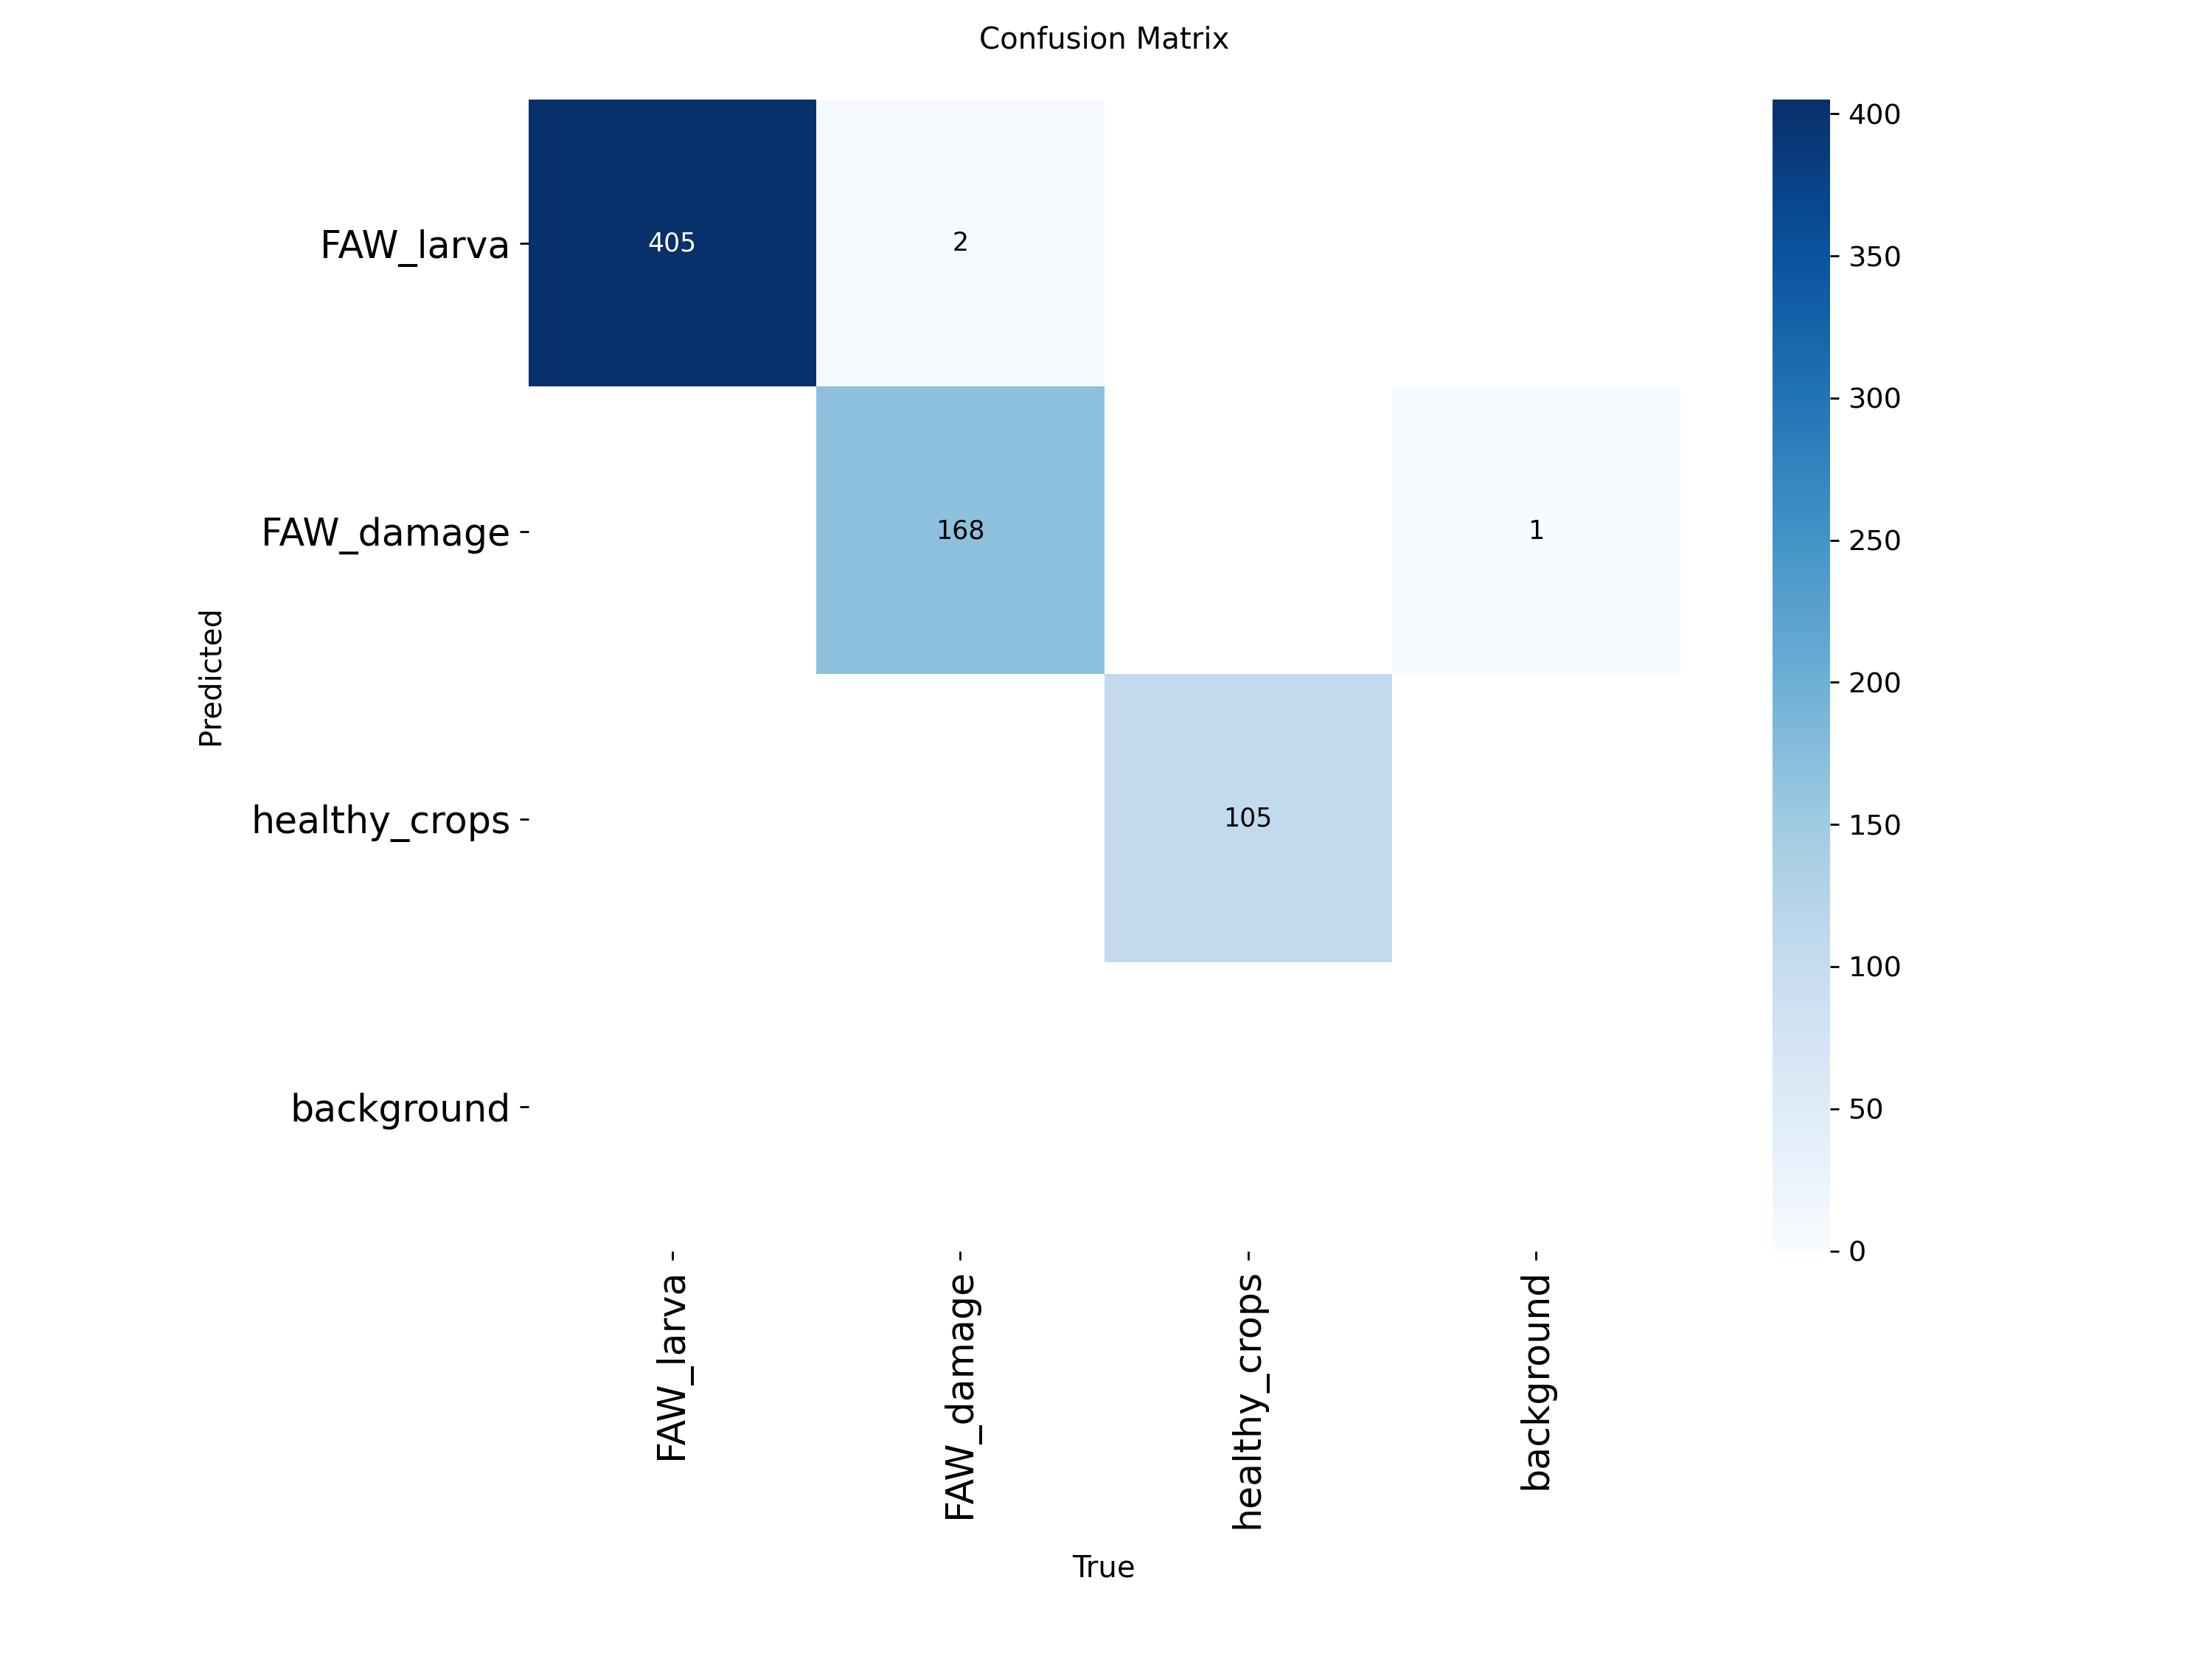


Displaying Results Plot:


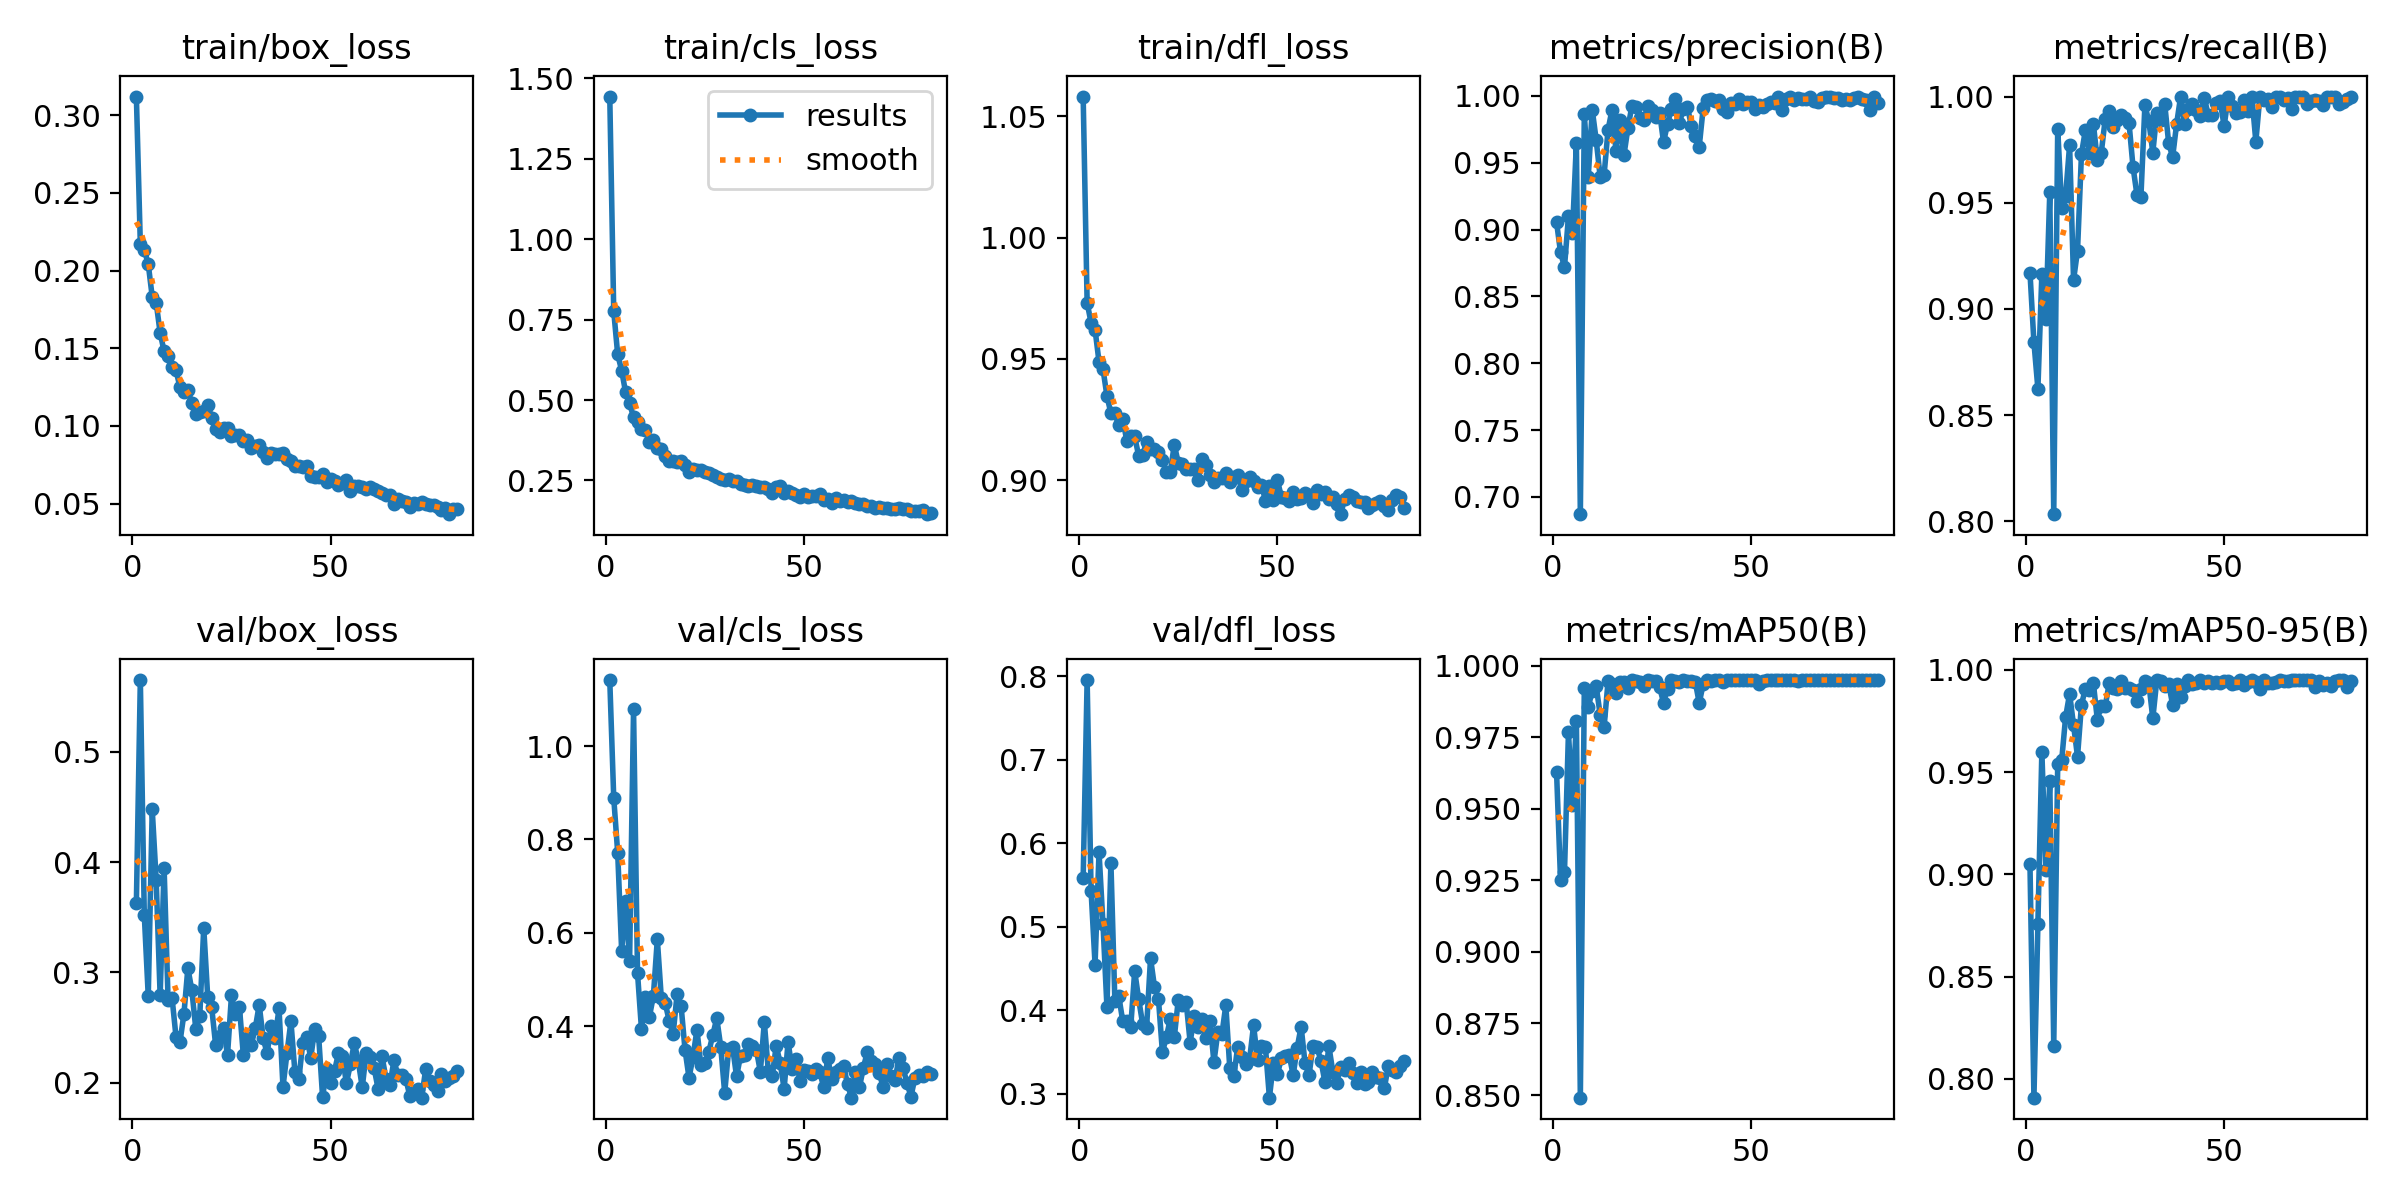

In [52]:
from IPython.display import Image, display
import os

# Define the base directory where the training results are saved
RUN_DIR = '/content/runs/detect/FAW_Object_Detection_Final'

# Define the paths to the specific visualization files
confusion_matrix_path = os.path.join(RUN_DIR, 'confusion_matrix.png')
results_plot_path = os.path.join(RUN_DIR, 'results.png')

print("Displaying Confusion Matrix:")
if os.path.exists(confusion_matrix_path):
    display(Image(filename=confusion_matrix_path))
else:
    print(f"❌ Error: Confusion matrix not found at {confusion_matrix_path}")

print("\nDisplaying Results Plot:")
if os.path.exists(results_plot_path):
    display(Image(filename=results_plot_path))
else:
    print(f"❌ Error: Results plot not found at {results_plot_path}")